In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import sys
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, ReLU, Lambda
 

# Part 1 - Data Preprocessing 

In [2]:
class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """

    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):

        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(os.path.join(base_path, "gt_image"))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id) / float(self.batch_size)))

    def __load__(self, id_name):
        image_path = os.path.join(self.base_path, "gt_image", (id_name ))
        label_path = os.path.join(self.base_path, "gt_binary_image", (id_name ))
        #print(image_path)
        image = cv2.imread(image_path, 1)  # Reading Image in RGB format
        image = cv2.resize(image, (self.img_size, self.img_size))
        # image = cv2.resize(image, (int(img.shape[1]/2), int(img.shape[0]/2)))
        #print(label_path)
        mask = cv2.imread(label_path, 1)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        # mask = cv2.resize(mask, (int(img.shape[1]/2), int(img.shape[0]/2)))

        # Normalizing the image
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.id):
            file_batch = self.id[index * self.batch_size:]
        else:
            file_batch = self.id[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for id_name in file_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)




# Part 2 - Model

In [3]:
def simple_unet_model(IMG_HEIGHT=256, IMG_WIDTH =256, IMG_CHANNELS = 3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255.0)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path bin
    u6_bin = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_bin = concatenate([u6_bin, c4])
    c6_bin = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_bin)
    c6_bin = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_bin)
     
    u7_bin = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_bin)
    u7_bin = concatenate([u7_bin, c3])
    c7_bin = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_bin)
    c7_bin = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_bin)
     
    u8_bin = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_bin)
    u8_bin = concatenate([u8_bin, c2])
    c8_bin = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_bin)
    c8_bin = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_bin)
     
    u9_bin = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_bin)
    u9_bin = concatenate([u9_bin, c1], axis=3)
    c9_bin = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_bin)
    c9_bin = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_bin)
     
    bin_seg = Conv2D(1, (1, 1), activation='sigmoid', name='bin_seg')(c9_bin)
    
   
     
    model = Model(inputs=[inputs], outputs=[bin_seg])
    
    return model

# Evaluation Metrics

In [4]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        
        return iou

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)



def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice
    

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# COMPILING MODEL

In [5]:

model = simple_unet_model()

checkpoint = ModelCheckpoint(r"C:\TUsimple_Unet\model", verbose=1, monitor ='val_loss',  save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

callbacks = [ checkpoint, reduce_lr]

opt = tf.keras.optimizers.experimental.Adam(1e-3)
metrics = [f1, iou , dice_coef ]

model.compile(loss=dice_coef_loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

train_generator = DataGenerator2D(r"E:\NU\TUsimple\train_set\training", img_size=256, batch_size=10, shuffle=True)
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256, batch_size=10, shuffle=False)

# Part 3 - Training

history = model.fit(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=20,
                              validation_steps=10,
                              epochs=100,
                              callbacks=callbacks)

print(history.history.keys())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 bin_seg (Conv2D)               (None, 256, 256, 1)  17          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.8961 - f1: 0.0969 - iou: 0.0556 - dice_coef: 0.1051
Epoch 1: val_loss improved from inf to 0.85767, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 26s 782ms/step - loss: 0.8961 - f1: 0.0969 - iou: 0.0556 - dice_coef: 0.1051 - val_loss: 0.8577 - val_f1: 0.1421 - val_iou: 0.0767 - val_dice_coef: 0.1423 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.8764 - f1: 0.1210 - iou: 0.0662 - dice_coef: 0.1236
Epoch 2: val_loss did not improve from 0.85767
20/20 [==============================] - 10s 468ms/step - loss: 0.8764 - f1: 0.1210 - iou: 0.0662 - dice_coef: 0.1236 - val_loss: 0.8944 - val_f1: 0.1019 - val_iou: 0.0558 - val_dice_coef: 0.1056 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.8339 - f1: 0.1673 - iou: 0.0920 - dice_coef: 0.1661
Epoch 3: val_loss improved from 0.85767 to 0.78812, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 581ms/step - loss: 0.8339 - f1: 0.1673 - iou: 0.0920 - dice_coef: 0.1661 - val_loss: 0.7881 - val_f1: 0.2207 - val_iou: 0.1201 - val_dice_coef: 0.2119 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.7695 - f1: 0.2310 - iou: 0.1318 - dice_coef: 0.2305
Epoch 4: val_loss improved from 0.78812 to 0.73936, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 12s 584ms/step - loss: 0.7695 - f1: 0.2310 - iou: 0.1318 - dice_coef: 0.2305 - val_loss: 0.7394 - val_f1: 0.2602 - val_iou: 0.1507 - val_dice_coef: 0.2606 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 0.7141 - f1: 0.2862 - iou: 0.1699 - dice_coef: 0.2859
Epoch 5: val_loss improved from 0.73936 to 0.72338, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 565ms/step - loss: 0.7141 - f1: 0.2862 - iou: 0.1699 - dice_coef: 0.2859 - val_loss: 0.7234 - val_f1: 0.2753 - val_iou: 0.1616 - val_dice_coef: 0.2766 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - ETA: 0s - loss: 0.7050 - f1: 0.2968 - iou: 0.1798 - dice_coef: 0.2950
Epoch 6: val_loss improved from 0.72338 to 0.69134, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 12s 609ms/step - loss: 0.7050 - f1: 0.2968 - iou: 0.1798 - dice_coef: 0.2950 - val_loss: 0.6913 - val_f1: 0.3150 - val_iou: 0.1878 - val_dice_coef: 0.3087 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 0.5615 - f1: 0.4401 - iou: 0.2874 - dice_coef: 0.4385
Epoch 7: val_loss improved from 0.69134 to 0.66319, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 13s 564ms/step - loss: 0.5615 - f1: 0.4401 - iou: 0.2874 - dice_coef: 0.4385 - val_loss: 0.6632 - val_f1: 0.3390 - val_iou: 0.2124 - val_dice_coef: 0.3368 - lr: 0.0010
Epoch 8/100
20/20 [==============================] - ETA: 0s - loss: 0.4626 - f1: 0.5404 - iou: 0.3821 - dice_coef: 0.5409
Epoch 8: val_loss improved from 0.66319 to 0.46120, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 565ms/step - loss: 0.4626 - f1: 0.5404 - iou: 0.3821 - dice_coef: 0.5409 - val_loss: 0.4612 - val_f1: 0.5408 - val_iou: 0.3767 - val_dice_coef: 0.5388 - lr: 0.0010
Epoch 9/100
20/20 [==============================] - ETA: 0s - loss: 0.3954 - f1: 0.6102 - iou: 0.4504 - dice_coef: 0.6046
Epoch 9: val_loss improved from 0.46120 to 0.44267, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 583ms/step - loss: 0.3954 - f1: 0.6102 - iou: 0.4504 - dice_coef: 0.6046 - val_loss: 0.4427 - val_f1: 0.5572 - val_iou: 0.3927 - val_dice_coef: 0.5573 - lr: 0.0010
Epoch 10/100
20/20 [==============================] - ETA: 0s - loss: 0.3825 - f1: 0.6209 - iou: 0.4594 - dice_coef: 0.6175
Epoch 10: val_loss improved from 0.44267 to 0.39281, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 522ms/step - loss: 0.3825 - f1: 0.6209 - iou: 0.4594 - dice_coef: 0.6175 - val_loss: 0.3928 - val_f1: 0.6072 - val_iou: 0.4521 - val_dice_coef: 0.6072 - lr: 0.0010
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 0.3401 - f1: 0.6641 - iou: 0.5111 - dice_coef: 0.6599
Epoch 11: val_loss improved from 0.39281 to 0.31793, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 548ms/step - loss: 0.3401 - f1: 0.6641 - iou: 0.5111 - dice_coef: 0.6599 - val_loss: 0.3179 - val_f1: 0.6854 - val_iou: 0.5356 - val_dice_coef: 0.6821 - lr: 0.0010
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 0.2706 - f1: 0.7320 - iou: 0.5939 - dice_coef: 0.7294
Epoch 12: val_loss did not improve from 0.31793
20/20 [==============================] - 9s 418ms/step - loss: 0.2706 - f1: 0.7320 - iou: 0.5939 - dice_coef: 0.7294 - val_loss: 0.3819 - val_f1: 0.6208 - val_iou: 0.4688 - val_dice_coef: 0.6181 - lr: 0.0010
Epoch 13/100
20/20 [==============================] - ETA: 0s - loss: 0.2828 - f1: 0.7233 - iou: 0.5832 - dice_coef: 0.7172
Epoch 13: val_loss did not improve from 0.31793
20/20 [==============================] - 8s 417ms/step - loss: 0.2828 - f1: 0.7233 - iou: 0.5832 - dice_coef: 0.7172 - val_loss: 0.3205 - val_f1: 0.6810 - val_iou: 0.5371 - val_dice_coef: 0.6795 - lr: 0.0010
Epoch 14/100
20/20 [===========

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 521ms/step - loss: 0.2502 - f1: 0.7548 - iou: 0.6266 - dice_coef: 0.7498 - val_loss: 0.2920 - val_f1: 0.7081 - val_iou: 0.5652 - val_dice_coef: 0.7080 - lr: 0.0010
Epoch 15/100
20/20 [==============================] - ETA: 0s - loss: 0.2007 - f1: 0.8043 - iou: 0.6911 - dice_coef: 0.7993
Epoch 15: val_loss improved from 0.29203 to 0.27014, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 528ms/step - loss: 0.2007 - f1: 0.8043 - iou: 0.6911 - dice_coef: 0.7993 - val_loss: 0.2701 - val_f1: 0.7321 - val_iou: 0.5972 - val_dice_coef: 0.7299 - lr: 0.0010
Epoch 16/100
20/20 [==============================] - ETA: 0s - loss: 0.1978 - f1: 0.8054 - iou: 0.6919 - dice_coef: 0.8022
Epoch 16: val_loss improved from 0.27014 to 0.25720, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 562ms/step - loss: 0.1978 - f1: 0.8054 - iou: 0.6919 - dice_coef: 0.8022 - val_loss: 0.2572 - val_f1: 0.7463 - val_iou: 0.6127 - val_dice_coef: 0.7428 - lr: 0.0010
Epoch 17/100
20/20 [==============================] - ETA: 0s - loss: 0.2230 - f1: 0.7846 - iou: 0.6655 - dice_coef: 0.7770
Epoch 17: val_loss improved from 0.25720 to 0.20975, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 504ms/step - loss: 0.2230 - f1: 0.7846 - iou: 0.6655 - dice_coef: 0.7770 - val_loss: 0.2098 - val_f1: 0.7921 - val_iou: 0.6698 - val_dice_coef: 0.7902 - lr: 0.0010
Epoch 18/100
20/20 [==============================] - ETA: 0s - loss: 0.1799 - f1: 0.8223 - iou: 0.7138 - dice_coef: 0.8201
Epoch 18: val_loss did not improve from 0.20975
20/20 [==============================] - 8s 378ms/step - loss: 0.1799 - f1: 0.8223 - iou: 0.7138 - dice_coef: 0.8201 - val_loss: 0.2114 - val_f1: 0.7918 - val_iou: 0.6722 - val_dice_coef: 0.7886 - lr: 0.0010
Epoch 19/100
20/20 [==============================] - ETA: 0s - loss: 0.1632 - f1: 0.8398 - iou: 0.7455 - dice_coef: 0.8368
Epoch 19: val_loss improved from 0.20975 to 0.19390, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 548ms/step - loss: 0.1632 - f1: 0.8398 - iou: 0.7455 - dice_coef: 0.8368 - val_loss: 0.1939 - val_f1: 0.8076 - val_iou: 0.6950 - val_dice_coef: 0.8061 - lr: 0.0010
Epoch 20/100
20/20 [==============================] - ETA: 0s - loss: 0.1430 - f1: 0.8568 - iou: 0.7775 - dice_coef: 0.8570
Epoch 20: val_loss improved from 0.19390 to 0.18112, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 514ms/step - loss: 0.1430 - f1: 0.8568 - iou: 0.7775 - dice_coef: 0.8570 - val_loss: 0.1811 - val_f1: 0.8189 - val_iou: 0.7180 - val_dice_coef: 0.8189 - lr: 0.0010
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 0.1025 - f1: 0.8997 - iou: 0.8423 - dice_coef: 0.8975
Epoch 21: val_loss improved from 0.18112 to 0.16362, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 11s 562ms/step - loss: 0.1025 - f1: 0.8997 - iou: 0.8423 - dice_coef: 0.8975 - val_loss: 0.1636 - val_f1: 0.8362 - val_iou: 0.7406 - val_dice_coef: 0.8364 - lr: 0.0010
Epoch 22/100
20/20 [==============================] - ETA: 0s - loss: 0.1461 - f1: 0.8533 - iou: 0.7739 - dice_coef: 0.8539
Epoch 22: val_loss did not improve from 0.16362
20/20 [==============================] - 10s 469ms/step - loss: 0.1461 - f1: 0.8533 - iou: 0.7739 - dice_coef: 0.8539 - val_loss: 0.2491 - val_f1: 0.7527 - val_iou: 0.6207 - val_dice_coef: 0.7509 - lr: 0.0010
Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.1492 - f1: 0.8529 - iou: 0.7648 - dice_coef: 0.8508
Epoch 23: val_loss did not improve from 0.16362
20/20 [==============================] - 8s 380ms/step - loss: 0.1492 - f1: 0.8529 - iou: 0.7648 - dice_coef: 0.8508 - val_loss: 0.1687 - val_f1: 0.8324 - val_iou: 0.7360 - val_dice_coef: 0.8313 - lr: 0.0010
Epoch 24/100
20/20 [==========

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 506ms/step - loss: 0.1139 - f1: 0.8876 - iou: 0.8223 - dice_coef: 0.8861 - val_loss: 0.1250 - val_f1: 0.8764 - val_iou: 0.8007 - val_dice_coef: 0.8750 - lr: 5.0000e-04
Epoch 26/100
20/20 [==============================] - ETA: 0s - loss: 0.0784 - f1: 0.9230 - iou: 0.8903 - dice_coef: 0.9216
Epoch 26: val_loss did not improve from 0.12499
20/20 [==============================] - 7s 363ms/step - loss: 0.0784 - f1: 0.9230 - iou: 0.8903 - dice_coef: 0.9216 - val_loss: 0.1288 - val_f1: 0.8717 - val_iou: 0.7992 - val_dice_coef: 0.8712 - lr: 5.0000e-04
Epoch 27/100
20/20 [==============================] - ETA: 0s - loss: 0.0906 - f1: 0.9101 - iou: 0.8666 - dice_coef: 0.9094
Epoch 27: val_loss improved from 0.12499 to 0.11225, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 482ms/step - loss: 0.0906 - f1: 0.9101 - iou: 0.8666 - dice_coef: 0.9094 - val_loss: 0.1123 - val_f1: 0.8890 - val_iou: 0.8211 - val_dice_coef: 0.8877 - lr: 5.0000e-04
Epoch 28/100
20/20 [==============================] - ETA: 0s - loss: 0.0903 - f1: 0.9104 - iou: 0.8627 - dice_coef: 0.9097
Epoch 28: val_loss did not improve from 0.11225
20/20 [==============================] - 7s 360ms/step - loss: 0.0903 - f1: 0.9104 - iou: 0.8627 - dice_coef: 0.9097 - val_loss: 0.1256 - val_f1: 0.8753 - val_iou: 0.8039 - val_dice_coef: 0.8744 - lr: 5.0000e-04
Epoch 29/100
20/20 [==============================] - ETA: 0s - loss: 0.0593 - f1: 0.9406 - iou: 0.9141 - dice_coef: 0.9407
Epoch 29: val_loss did not improve from 0.11225
20/20 [==============================] - 8s 381ms/step - loss: 0.0593 - f1: 0.9406 - iou: 0.9141 - dice_coef: 0.9407 - val_loss: 0.1175 - val_f1: 0.8838 - val_iou: 0.8204 - val_dice_coef: 0.8825 - lr: 5.0000e-04
Epoch 30/100
20/20 

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 500ms/step - loss: 0.0889 - f1: 0.9122 - iou: 0.8672 - dice_coef: 0.9111 - val_loss: 0.1079 - val_f1: 0.8940 - val_iou: 0.8351 - val_dice_coef: 0.8921 - lr: 2.5000e-04
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.0517 - f1: 0.9494 - iou: 0.9270 - dice_coef: 0.9483
Epoch 33: val_loss improved from 0.10791 to 0.08702, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 483ms/step - loss: 0.0517 - f1: 0.9494 - iou: 0.9270 - dice_coef: 0.9483 - val_loss: 0.0870 - val_f1: 0.9141 - val_iou: 0.8687 - val_dice_coef: 0.9130 - lr: 2.5000e-04
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.0556 - f1: 0.9436 - iou: 0.9247 - dice_coef: 0.9444
Epoch 34: val_loss improved from 0.08702 to 0.08668, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 478ms/step - loss: 0.0556 - f1: 0.9436 - iou: 0.9247 - dice_coef: 0.9444 - val_loss: 0.0867 - val_f1: 0.9147 - val_iou: 0.8677 - val_dice_coef: 0.9133 - lr: 2.5000e-04
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 0.0424 - f1: 0.9592 - iou: 0.9491 - dice_coef: 0.9576
Epoch 35: val_loss did not improve from 0.08668
20/20 [==============================] - 8s 369ms/step - loss: 0.0424 - f1: 0.9592 - iou: 0.9491 - dice_coef: 0.9576 - val_loss: 0.1002 - val_f1: 0.9003 - val_iou: 0.8476 - val_dice_coef: 0.8998 - lr: 2.5000e-04
Epoch 36/100
20/20 [==============================] - ETA: 0s - loss: 0.0538 - f1: 0.9469 - iou: 0.9282 - dice_coef: 0.9462
Epoch 36: val_loss did not improve from 0.08668
20/20 [==============================] - 8s 381ms/step - loss: 0.0538 - f1: 0.9469 - iou: 0.9282 - dice_coef: 0.9462 - val_loss: 0.1046 - val_f1: 0.8962 - val_iou: 0.8398 - val_dice_coef: 0.8954 - lr: 2.5000e-04
Epoch 37/100
20/20 

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 500ms/step - loss: 0.0408 - f1: 0.9598 - iou: 0.9586 - dice_coef: 0.9592 - val_loss: 0.0803 - val_f1: 0.9204 - val_iou: 0.8774 - val_dice_coef: 0.9197 - lr: 2.5000e-04
Epoch 38/100
20/20 [==============================] - ETA: 0s - loss: 0.0289 - f1: 0.9698 - iou: 0.9746 - dice_coef: 0.9711
Epoch 38: val_loss did not improve from 0.08031
20/20 [==============================] - 8s 386ms/step - loss: 0.0289 - f1: 0.9698 - iou: 0.9746 - dice_coef: 0.9711 - val_loss: 0.0857 - val_f1: 0.9158 - val_iou: 0.8702 - val_dice_coef: 0.9143 - lr: 2.5000e-04
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.0621 - f1: 0.9371 - iou: 0.9120 - dice_coef: 0.9379
Epoch 39: val_loss improved from 0.08031 to 0.07527, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 497ms/step - loss: 0.0621 - f1: 0.9371 - iou: 0.9120 - dice_coef: 0.9379 - val_loss: 0.0753 - val_f1: 0.9266 - val_iou: 0.8848 - val_dice_coef: 0.9247 - lr: 2.5000e-04
Epoch 40/100
20/20 [==============================] - ETA: 0s - loss: 0.0348 - f1: 0.9660 - iou: 0.9655 - dice_coef: 0.9652
Epoch 40: val_loss did not improve from 0.07527
20/20 [==============================] - 7s 343ms/step - loss: 0.0348 - f1: 0.9660 - iou: 0.9655 - dice_coef: 0.9652 - val_loss: 0.0846 - val_f1: 0.9158 - val_iou: 0.8725 - val_dice_coef: 0.9154 - lr: 2.5000e-04
Epoch 41/100
20/20 [==============================] - ETA: 0s - loss: 0.0691 - f1: 0.9303 - iou: 0.9020 - dice_coef: 0.9309
Epoch 41: val_loss did not improve from 0.07527
20/20 [==============================] - 7s 370ms/step - loss: 0.0691 - f1: 0.9303 - iou: 0.9020 - dice_coef: 0.9309 - val_loss: 0.0811 - val_f1: 0.9198 - val_iou: 0.8765 - val_dice_coef: 0.9189 - lr: 2.5000e-04
Epoch 42/100
20/20 

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 480ms/step - loss: 0.0321 - f1: 0.9673 - iou: 0.9677 - dice_coef: 0.9679 - val_loss: 0.0729 - val_f1: 0.9277 - val_iou: 0.8948 - val_dice_coef: 0.9271 - lr: 1.2500e-04
Epoch 45/100
20/20 [==============================] - ETA: 0s - loss: 0.0420 - f1: 0.9559 - iou: 0.9558 - dice_coef: 0.9580
Epoch 45: val_loss did not improve from 0.07294
20/20 [==============================] - 7s 352ms/step - loss: 0.0420 - f1: 0.9559 - iou: 0.9558 - dice_coef: 0.9580 - val_loss: 0.0761 - val_f1: 0.9246 - val_iou: 0.8870 - val_dice_coef: 0.9239 - lr: 1.2500e-04
Epoch 46/100
20/20 [==============================] - ETA: 0s - loss: 0.0291 - f1: 0.9716 - iou: 0.9729 - dice_coef: 0.9709
Epoch 46: val_loss improved from 0.07294 to 0.06985, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 489ms/step - loss: 0.0291 - f1: 0.9716 - iou: 0.9729 - dice_coef: 0.9709 - val_loss: 0.0699 - val_f1: 0.9313 - val_iou: 0.8986 - val_dice_coef: 0.9301 - lr: 1.2500e-04
Epoch 47/100
20/20 [==============================] - ETA: 0s - loss: 0.0372 - f1: 0.9610 - iou: 0.9537 - dice_coef: 0.9628
Epoch 47: val_loss improved from 0.06985 to 0.06698, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 520ms/step - loss: 0.0372 - f1: 0.9610 - iou: 0.9537 - dice_coef: 0.9628 - val_loss: 0.0670 - val_f1: 0.9346 - val_iou: 0.9040 - val_dice_coef: 0.9330 - lr: 1.2500e-04
Epoch 48/100
20/20 [==============================] - ETA: 0s - loss: 0.0476 - f1: 0.9527 - iou: 0.9402 - dice_coef: 0.9524
Epoch 48: val_loss did not improve from 0.06698
20/20 [==============================] - 7s 325ms/step - loss: 0.0476 - f1: 0.9527 - iou: 0.9402 - dice_coef: 0.9524 - val_loss: 0.0708 - val_f1: 0.9300 - val_iou: 0.8961 - val_dice_coef: 0.9292 - lr: 1.2500e-04
Epoch 49/100
20/20 [==============================] - ETA: 0s - loss: 0.0193 - f1: 0.9811 - iou: 0.9892 - dice_coef: 0.9807
Epoch 49: val_loss did not improve from 0.06698
20/20 [==============================] - 7s 355ms/step - loss: 0.0193 - f1: 0.9811 - iou: 0.9892 - dice_coef: 0.9807 - val_loss: 0.0687 - val_f1: 0.9324 - val_iou: 0.9021 - val_dice_coef: 0.9313 - lr: 1.2500e-04
Epoch 50/100
20/20 

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 497ms/step - loss: 0.0166 - f1: 0.9846 - iou: 0.9960 - dice_coef: 0.9834 - val_loss: 0.0659 - val_f1: 0.9357 - val_iou: 0.9058 - val_dice_coef: 0.9341 - lr: 1.2500e-04
Epoch 51/100
20/20 [==============================] - ETA: 0s - loss: 0.0360 - f1: 0.9640 - iou: 0.9617 - dice_coef: 0.9640
Epoch 51: val_loss did not improve from 0.06585
20/20 [==============================] - 7s 347ms/step - loss: 0.0360 - f1: 0.9640 - iou: 0.9617 - dice_coef: 0.9640 - val_loss: 0.0755 - val_f1: 0.9258 - val_iou: 0.8932 - val_dice_coef: 0.9245 - lr: 1.2500e-04
Epoch 52/100
20/20 [==============================] - ETA: 0s - loss: 0.0159 - f1: 0.9828 - iou: 1.0031 - dice_coef: 0.9841
Epoch 52: val_loss did not improve from 0.06585
20/20 [==============================] - 7s 357ms/step - loss: 0.0159 - f1: 0.9828 - iou: 1.0031 - dice_coef: 0.9841 - val_loss: 0.0690 - val_f1: 0.9335 - val_iou: 0.9039 - val_dice_coef: 0.9310 - lr: 1.2500e-04
Epoch 53/100
20/20 

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 476ms/step - loss: 0.0050 - f1: 0.9950 - iou: 1.0207 - dice_coef: 0.9950 - val_loss: 0.0639 - val_f1: 0.9377 - val_iou: 0.9106 - val_dice_coef: 0.9361 - lr: 6.2500e-05
Epoch 56/100
20/20 [==============================] - ETA: 0s - loss: 0.0199 - f1: 0.9824 - iou: 0.9899 - dice_coef: 0.9801
Epoch 56: val_loss did not improve from 0.06391
20/20 [==============================] - 7s 359ms/step - loss: 0.0199 - f1: 0.9824 - iou: 0.9899 - dice_coef: 0.9801 - val_loss: 0.0648 - val_f1: 0.9372 - val_iou: 0.9104 - val_dice_coef: 0.9352 - lr: 6.2500e-05
Epoch 57/100
20/20 [==============================] - ETA: 0s - loss: 0.0232 - f1: 0.9759 - iou: 0.9842 - dice_coef: 0.9761
Epoch 57: val_loss improved from 0.06391 to 0.06309, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 462ms/step - loss: 0.0232 - f1: 0.9759 - iou: 0.9842 - dice_coef: 0.9761 - val_loss: 0.0631 - val_f1: 0.9387 - val_iou: 0.9125 - val_dice_coef: 0.9369 - lr: 6.2500e-05
Epoch 58/100
20/20 [==============================] - ETA: 0s - loss: 0.0032 - f1: 0.9979 - iou: 1.0317 - dice_coef: 0.9968
Epoch 58: val_loss did not improve from 0.06309
20/20 [==============================] - 7s 336ms/step - loss: 0.0032 - f1: 0.9979 - iou: 1.0317 - dice_coef: 0.9968 - val_loss: 0.0641 - val_f1: 0.9371 - val_iou: 0.9112 - val_dice_coef: 0.9359 - lr: 6.2500e-05
Epoch 59/100
20/20 [==============================] - ETA: 0s - loss: 0.0098 - f1: 0.9910 - iou: 1.0117 - dice_coef: 0.9902
Epoch 59: val_loss improved from 0.06309 to 0.06168, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 472ms/step - loss: 0.0098 - f1: 0.9910 - iou: 1.0117 - dice_coef: 0.9902 - val_loss: 0.0617 - val_f1: 0.9397 - val_iou: 0.9153 - val_dice_coef: 0.9383 - lr: 6.2500e-05
Epoch 60/100
20/20 [==============================] - ETA: 0s - loss: 0.0099 - f1: 0.9900 - iou: 1.0103 - dice_coef: 0.9901
Epoch 60: val_loss did not improve from 0.06168
20/20 [==============================] - 7s 337ms/step - loss: 0.0099 - f1: 0.9900 - iou: 1.0103 - dice_coef: 0.9901 - val_loss: 0.0651 - val_f1: 0.9361 - val_iou: 0.9093 - val_dice_coef: 0.9349 - lr: 6.2500e-05
Epoch 61/100
20/20 [==============================] - ETA: 0s - loss: 0.0077 - f1: 0.9932 - iou: 1.0172 - dice_coef: 0.9923
Epoch 61: val_loss improved from 0.06168 to 0.06102, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 480ms/step - loss: 0.0077 - f1: 0.9932 - iou: 1.0172 - dice_coef: 0.9923 - val_loss: 0.0610 - val_f1: 0.9406 - val_iou: 0.9154 - val_dice_coef: 0.9390 - lr: 6.2500e-05
Epoch 62/100
20/20 [==============================] - ETA: 0s - loss: 0.0064 - f1: 0.9932 - iou: 1.0266 - dice_coef: 0.9936    
Epoch 62: val_loss did not improve from 0.06102
20/20 [==============================] - 7s 343ms/step - loss: 0.0064 - f1: 0.9932 - iou: 1.0266 - dice_coef: 0.9936 - val_loss: 0.0654 - val_f1: 0.9363 - val_iou: 0.9111 - val_dice_coef: 0.9346 - lr: 6.2500e-05
Epoch 63/100
20/20 [==============================] - ETA: 0s - loss: 0.0097 - f1: 0.9907 - iou: 1.0117 - dice_coef: 0.9903
Epoch 63: val_loss did not improve from 0.06102
20/20 [==============================] - 7s 346ms/step - loss: 0.0097 - f1: 0.9907 - iou: 1.0117 - dice_coef: 0.9903 - val_loss: 0.0612 - val_f1: 0.9406 - val_iou: 0.9173 - val_dice_coef: 0.9388 - lr: 6.2500e-05
Epoch 64/100
20/

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 468ms/step - loss: 0.0098 - f1: 0.9906 - iou: 1.0070 - dice_coef: 0.9902 - val_loss: 0.0598 - val_f1: 0.9418 - val_iou: 0.9195 - val_dice_coef: 0.9402 - lr: 3.1250e-05
Epoch 68/100
20/20 [==============================] - ETA: 0s - loss: 0.0255 - f1: 0.9745 - iou: 0.9817 - dice_coef: 0.9745
Epoch 68: val_loss improved from 0.05983 to 0.05945, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 10s 481ms/step - loss: 0.0255 - f1: 0.9745 - iou: 0.9817 - dice_coef: 0.9745 - val_loss: 0.0595 - val_f1: 0.9421 - val_iou: 0.9193 - val_dice_coef: 0.9405 - lr: 3.1250e-05
Epoch 69/100
20/20 [==============================] - ETA: 0s - loss: 0.0425 - f1: 0.9581 - iou: 0.9501 - dice_coef: 0.9575
Epoch 69: val_loss improved from 0.05945 to 0.05783, saving model to C:\TUsimple_Unet\model


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 453ms/step - loss: 0.0425 - f1: 0.9581 - iou: 0.9501 - dice_coef: 0.9575 - val_loss: 0.0578 - val_f1: 0.9440 - val_iou: 0.9206 - val_dice_coef: 0.9422 - lr: 3.1250e-05
Epoch 70/100
20/20 [==============================] - ETA: 0s - loss: 0.0292 - f1: 0.9704 - iou: 0.9707 - dice_coef: 0.9708
Epoch 70: val_loss did not improve from 0.05783
20/20 [==============================] - 7s 339ms/step - loss: 0.0292 - f1: 0.9704 - iou: 0.9707 - dice_coef: 0.9708 - val_loss: 0.0595 - val_f1: 0.9420 - val_iou: 0.9191 - val_dice_coef: 0.9405 - lr: 3.1250e-05
Epoch 71/100
20/20 [==============================] - ETA: 0s - loss: 0.0220 - f1: 0.9795 - iou: 0.9909 - dice_coef: 0.9780
Epoch 71: val_loss did not improve from 0.05783
20/20 [==============================] - 7s 366ms/step - loss: 0.0220 - f1: 0.9795 - iou: 0.9909 - dice_coef: 0.9780 - val_loss: 0.0589 - val_f1: 0.9429 - val_iou: 0.9214 - val_dice_coef: 0.9411 - lr: 3.1250e-05
Epoch 72/100
20/20 [

INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_Unet\model\assets


20/20 [==============================] - 9s 466ms/step - loss: 0.0107 - f1: 0.9902 - iou: 1.0059 - dice_coef: 0.9893 - val_loss: 0.0571 - val_f1: 0.9446 - val_iou: 0.9233 - val_dice_coef: 0.9429 - lr: 1.5625e-05
Epoch 74/100
20/20 [==============================] - ETA: 0s - loss: 0.0202 - f1: 0.9809 - iou: 0.9939 - dice_coef: 0.9798
Epoch 74: val_loss did not improve from 0.05713
20/20 [==============================] - 7s 340ms/step - loss: 0.0202 - f1: 0.9809 - iou: 0.9939 - dice_coef: 0.9798 - val_loss: 0.0580 - val_f1: 0.9439 - val_iou: 0.9231 - val_dice_coef: 0.9420 - lr: 1.5625e-05
Epoch 75/100
20/20 [==============================] - ETA: 0s - loss: 0.0182 - f1: 0.9823 - iou: 0.9967 - dice_coef: 0.9818
Epoch 75: val_loss did not improve from 0.05713
20/20 [==============================] - 7s 352ms/step - loss: 0.0182 - f1: 0.9823 - iou: 0.9967 - dice_coef: 0.9818 - val_loss: 0.0584 - val_f1: 0.9434 - val_iou: 0.9227 - val_dice_coef: 0.9416 - lr: 1.5625e-05
Epoch 76/100
20/20 [

Epoch 94/100
20/20 [==============================] - ETA: 0s - loss: 0.0032 - f1: 0.9962 - iou: 1.0221 - dice_coef: 0.9968     
Epoch 94: val_loss did not improve from 0.05713
20/20 [==============================] - 7s 350ms/step - loss: 0.0032 - f1: 0.9962 - iou: 1.0221 - dice_coef: 0.9968 - val_loss: 0.0586 - val_f1: 0.9430 - val_iou: 0.9228 - val_dice_coef: 0.9414 - lr: 1.0000e-06
Epoch 95/100
20/20 [==============================] - ETA: 0s - loss: 0.0017 - f1: 0.9968 - iou: 1.0328 - dice_coef: 0.9983
Epoch 95: val_loss did not improve from 0.05713
20/20 [==============================] - 7s 347ms/step - loss: 0.0017 - f1: 0.9968 - iou: 1.0328 - dice_coef: 0.9983 - val_loss: 0.0587 - val_f1: 0.9429 - val_iou: 0.9226 - val_dice_coef: 0.9413 - lr: 1.0000e-06
Epoch 96/100
20/20 [==============================] - ETA: 0s - loss: 0.0134 - f1: 0.9865 - iou: 1.0065 - dice_coef: 0.9866
Epoch 96: val_loss did not improve from 0.05713
20/20 [==============================] - 7s 345ms/step 

# Part 4 - Visualization

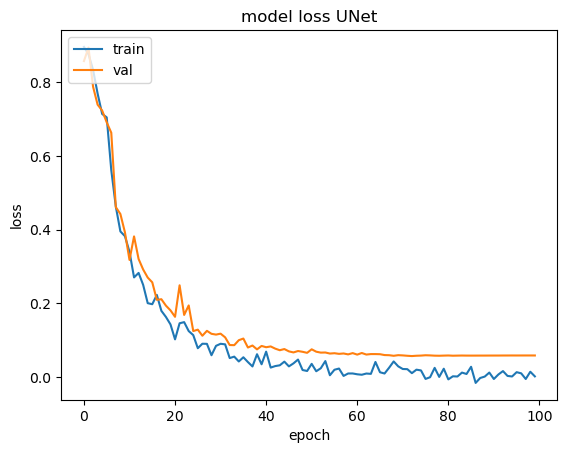

In [6]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss UNet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


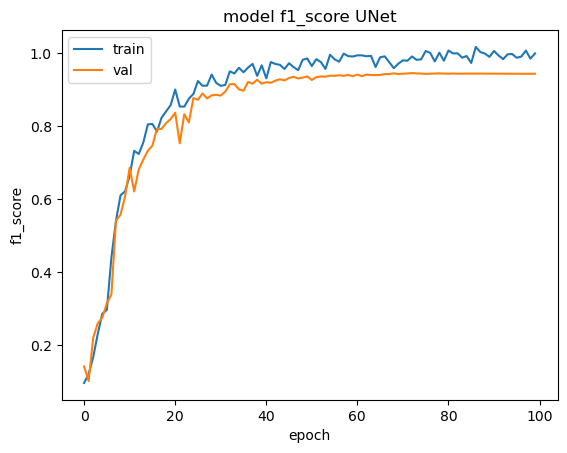

In [7]:
# summarize history for F1

plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1_score UNet')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


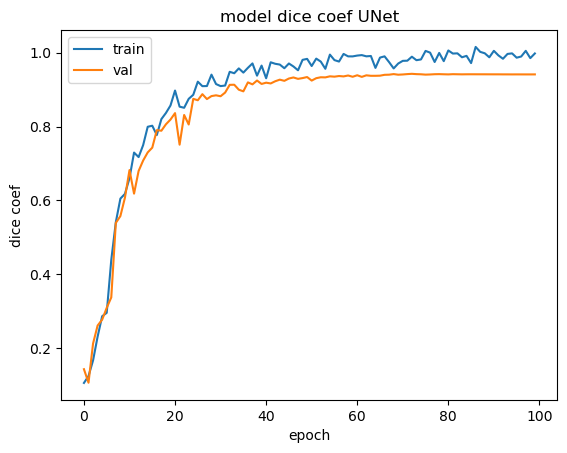

In [8]:
# summarize history for dice_coef

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice coef UNet')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate 

In [6]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256,batch_size=128, shuffle=True)
model = simple_unet_model()
model.load_weights(r'C:\TUsimple_Unet\model')
model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = model.evaluate(val_generator,batch_size= 60, verbose=1,)

4/4 [==============================] - 21s 6s/step - loss: 0.0458 - f1: 0.9563 - iou: 0.9370 - dice_coef: 0.9542


4/4 [==============================] - 2s 54ms/step


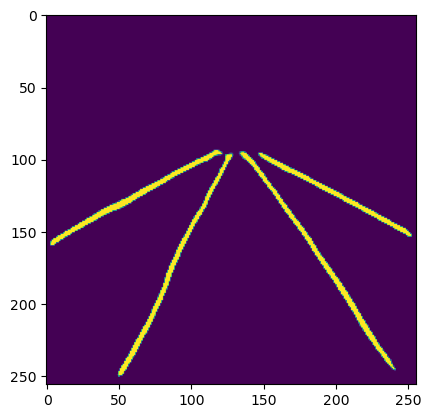

In [9]:


val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\testing", img_size=256,batch_size=128, shuffle=False)
X, y = val_generator.__getitem__(0)

predict = model.predict(X)
img = predict[2]
plt.imshow(img)


In [10]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\testing", img_size=256,batch_size=128, shuffle=True)
X, y = val_generator.__getitem__(0)
predict = model.predict(X)




4/4 [==============================] - 0s 123ms/step


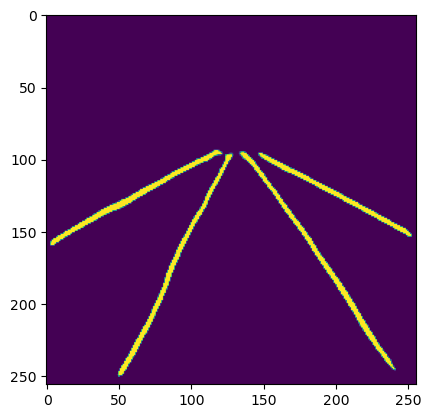

In [11]:
img = predict[2]
plt.imshow(img)

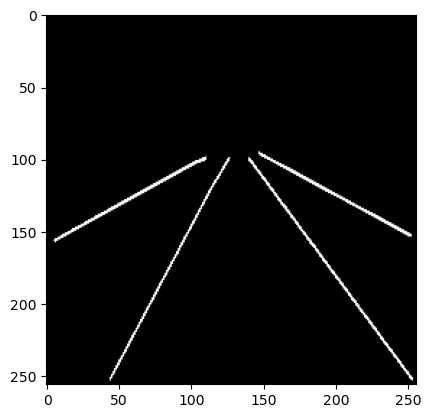

In [12]:
plt.imshow(y[2])

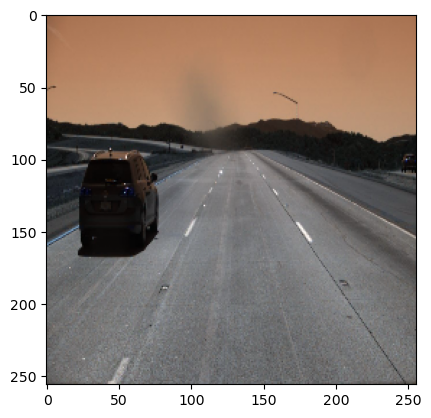

In [12]:
plt.imshow(X[2])